# Ahead of time flood prediction using LSTM



In [0]:
#Flood Early Warning System using IoT and Edge 

#Eric Samikwa

In [0]:
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from matplotlib import pyplot
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense     
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')


# Data pre-processing

In [0]:
# fix random seed for reproducibility of results
np.random.seed(10)

### Hourly rainfall data

In [0]:
df_rain = pandas.read_csv("/content/hourly_rainfall_train.csv")

In [162]:
#display first 5
df_rain.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm)
0,2018-12-02 18:00:00,0.0,0.0
1,2018-12-02 17:00:00,0.0,0.0
2,2018-12-02 16:00:00,0.0,0.0
3,2018-12-02 15:00:00,0.0,0.0
4,2018-12-02 14:00:00,0.0,0.0


In [163]:
#dataframe shape
df_rain.shape

(78848, 3)

In [164]:
#dataset properties
df_rain.describe()  


,Current rainfall (mm),Cumulative rainfall (mm)
count,78844.000000,78847.000000
mean,0.049206,0.586580
std,0.765296,2.770216
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,110.000000,111.400000


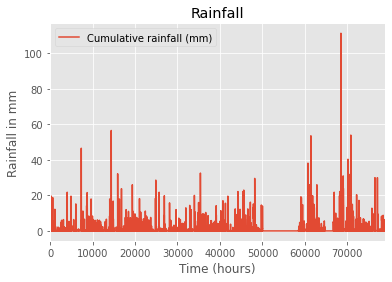

In [165]:
df_rain.plot( y='Cumulative rainfall (mm)')  

plt.title('Rainfall')  
plt.xlabel('Time (hours)')  
plt.ylabel('Rainfall in mm')  
plt.show()  

### Hourly water level data

In [0]:
df_water_level = pandas.read_csv("/content/hourly_water_level_train.csv")

In [167]:
df_water_level.head()

,Date/Time,Level (m)
0,2018-12-02 17:00:00,1.61
1,2018-12-02 16:00:00,1.61
2,2018-12-02 15:00:00,1.62
3,2018-12-02 14:00:00,1.63
4,2018-12-02 13:00:00,1.63


In [168]:
df_water_level.shape

(78822, 2)

In [169]:
#dataset properties
df_water_level.describe()

,Level (m)
count,78822.000000
mean,1.453701
std,0.113859
min,0.000000
25%,1.400000
50%,1.450000
75%,1.500000
max,3.300000


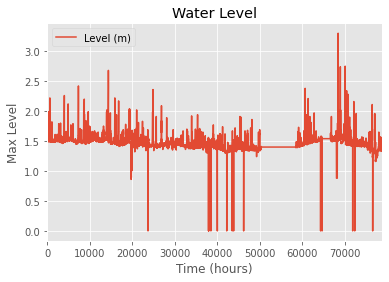

In [170]:
df_water_level.plot(y='Level (m)')  
plt.title('Water Level')  
plt.xlabel('Time (hours)')  
plt.ylabel('Max Level')  
plt.show() 

### Combining dataset

In [171]:
#dataset merged on date_time 
dataset = pandas.merge(df_rain, df_water_level, how='outer', on=['Date/Time'])
dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,NaN
1,2018-12-02 17:00:00,0.0,0.0,1.61
2,2018-12-02 16:00:00,0.0,0.0,1.61
3,2018-12-02 15:00:00,0.0,0.0,1.62
4,2018-12-02 14:00:00,0.0,0.0,1.63


### Filling missing values

In [172]:
#filling all missing values with mean of the column
dataset['Cumulative rainfall (mm)'] = dataset['Cumulative rainfall (mm)'].fillna(dataset['Cumulative rainfall (mm)'].mean())
dataset['Level (m)'] = dataset['Level (m)'].fillna(dataset['Level (m)'].mean())

dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,1.453701
1,2018-12-02 17:00:00,0.0,0.0,1.610000
2,2018-12-02 16:00:00,0.0,0.0,1.610000
3,2018-12-02 15:00:00,0.0,0.0,1.620000
4,2018-12-02 14:00:00,0.0,0.0,1.630000


### Removing unwanted columns

In [173]:
dataset = dataset.drop(columns=['Current rainfall (mm)', 'Date/Time'])
dataset.shape

(78850, 2)

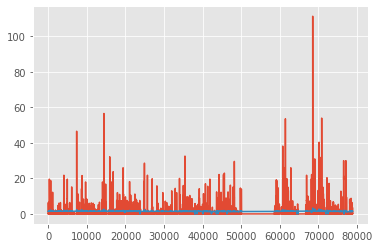

In [174]:
plt.plot(dataset)

### Scaling dataset 

In [0]:
# normalize the dataset (LSTMs are sensitive to the scale of the input data)
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [176]:
print(dataset[0])

[0.         0.44051556]


# Training 

### Dataset sliding window (Multivariate)

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [178]:
# specify the number of lag hours
n_hours = 10
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(dataset, n_hours, 1)
print(reframed.shape)

(78840, 22)


In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 55100
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

----------------- TRAINING DATA -----------------


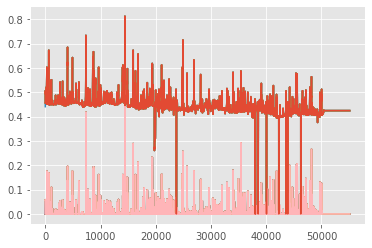

----------------- TEST DATA -----------------


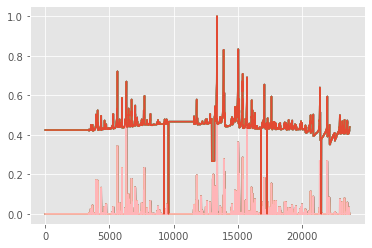

In [180]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

In [206]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

(55100, 20) 55100 (55100,)


In [214]:
print(train_X[1])
print(train_y[0])

[[0.         0.48787879]
 [0.         0.48787879]
 [0.         0.49090909]
 [0.         0.49393939]
 [0.         0.49393939]
 [0.         0.49393939]
 [0.         0.49393939]
 [0.         0.49393939]
 [0.05745063 0.49393939]
 [0.05745063 0.49393939]]
0.4939393939393939


In [246]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(55100, 10, 2) (55100,) (23740, 10, 2) (23740, 1)


## Model (LSTM)

In [0]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4,input_shape=(train_X.shape[1], train_X.shape[2]),activation='relu',recurrent_activation='relu',use_bias=True,dropout=0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [185]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


## Model Learning

In [186]:
#training : 4 epochs and batch size 1
history = model.fit(train_X, train_y, nb_epoch=4, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 55100 samples, validate on 23740 samples
Epoch 1/4
 - 253s - loss: 0.0012 - val_loss: 0.0022
Epoch 2/4
 - 269s - loss: 4.0003e-04 - val_loss: 0.0022
Epoch 3/4
 - 266s - loss: 4.0205e-04 - val_loss: 0.0022
Epoch 4/4
 - 255s - loss: 4.0138e-04 - val_loss: 0.0021


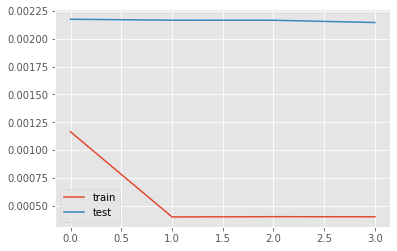

In [187]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Model Evaluation

In [192]:
# Print out the evaluation for both the
trainScore = model.evaluate(train_X, train_y, verbose=0)
trainScore = math.sqrt(trainScore)
#trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(test_X, test_y, verbose=0)
testScore = math.sqrt(testScore)
#testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.05 RMSE


# Testing

### Predictions

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [262]:
# invert scaling for forecast
inv_yhat = concatenate((yhat,test_X[:,-1:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
#x = scaler.inverse_transform(dataset[0])

inv_yhat = inv_yhat[:,0]
print(inv_yhat)

[0.42424244 0.42424244 0.42424244 ... 0.42424244 0.42424244 0.42424244]


In [0]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:,-1:],yhat), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [264]:
print(inv_y)

[0.42424242 0.42424242 0.42424242 ... 0.44051556 0.44051556 0.44051556]


In [250]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


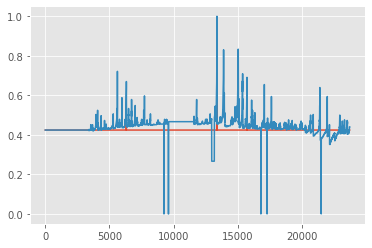

In [251]:
plt.plot(yhat)
plt.plot(test_y)

In [238]:
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict)+slide_window, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(slide_window*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: ignored

NameError: ignored

### Unseen data

In [0]:
# Test the network on an unseen data
unseen = pandas.read_csv('/content/flood_pred_test.csv',sep=',')

In [0]:
unseen.head()

In [0]:
unseen_test = unseen['Level (m)'].values

In [0]:
plt.plot(unseen_test[0:20000])

In [0]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

In [0]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, (109186,1, 10)) 

In [0]:
unseen_results = model.predict(features)

In [0]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(unseen_results)
plt.show()


print('-------------------- Ground Truth --------------------')
plt.plot(labels)
plt.show()

### Test scores

In [0]:
# Check the root mean squared error for the new test set

testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

In [0]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('----------------- Predicted ---------------')
plt.plot(unseen_results[0:20000])
plt.show()

print('----------------- Ground Truth ---------------')
plt.plot(labels[0:20000])
plt.show()